In [120]:
!pip install deap

In [121]:
!pip install bitstring

In [122]:
!pip install transforms3d

In [123]:
!pip install tsaug

In [124]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [125]:
pwd

'C:\\Users\\pc lenevo\\Desktop\\covid_3scenario\\data_complet'

In [126]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [127]:
df = pd.read_csv('C:/Users/pc lenevo/Desktop/covid_3scenario/data_complet/owid-covid-data.csv') # having First.csv zipped file.

In [128]:
# Informations dur les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36984 entries, 0 to 36983
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         36920 non-null  object 
 1   continent                        36691 non-null  object 
 2   location                         36984 non-null  object 
 3   date                             36984 non-null  object 
 4   total_cases                      36632 non-null  float64
 5   new_cases                        36632 non-null  float64
 6   total_deaths                     36632 non-null  float64
 7   new_deaths                       36632 non-null  float64
 8   total_cases_per_million          36568 non-null  float64
 9   new_cases_per_million            36568 non-null  float64
 10  total_deaths_per_million         36568 non-null  float64
 11  new_deaths_per_million           36568 non-null  float64
 12  new_tests         

In [129]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [130]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [131]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [132]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [133]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [134]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [135]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [136]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [137]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [138]:
df = df.fillna(df.median())

In [139]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [140]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [141]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [142]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [143]:
#df['month'] = df['date'].dt.month

In [144]:
# Parametrages sequences 
nb_seq=7
n_out=7
nb_col=5

In [145]:
start_date = '2020-03-02'
end_date = '2020-07-13'
start_date2 ='2020-07-12'
end_date2 = '2020-08-15'

In [146]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [147]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [148]:
df.sort_values(by=['location'], inplace=True)

In [149]:
X_train_1 = df.loc[mask1].sort_index(axis = 0) 
X_train_1.shape

(134, 7)

In [150]:
X_train_1.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco


In [151]:
X_train_1.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [152]:
#Date to add test set 
data_add_test = X_train_1[X_train_1.location =='Morocco'].tail(nb_seq)

In [153]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [154]:
X_train_1.shape

(134, 7)

In [155]:
X_train_1.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco
22933,7.0,615.0,10.0,0.0,36910558.0,2020-03-07,Morocco
22934,7.0,615.0,10.0,0.0,36910558.0,2020-03-08,Morocco
22935,7.0,615.0,10.0,0.0,36910558.0,2020-03-09,Morocco
22936,7.0,615.0,10.0,0.0,36910558.0,2020-03-10,Morocco
22937,7.0,615.0,10.0,0.0,36910558.0,2020-03-11,Morocco


In [156]:
X_train_1.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23052,319.0,13288.0,230.0,1.0,36910558.0,2020-07-04,Morocco
23053,534.0,13822.0,232.0,2.0,36910558.0,2020-07-05,Morocco
23054,393.0,14215.0,235.0,3.0,36910558.0,2020-07-06,Morocco
23055,114.0,14329.0,235.0,0.0,36910558.0,2020-07-07,Morocco
23056,0.0,14329.0,235.0,0.0,36910558.0,2020-07-08,Morocco
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [157]:
X_test_1 = df.loc[mask2].sort_index(axis = 0) 

X_test_1.shape

(35, 7)

In [158]:
X_test_1

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
23062,191.0,15936.0,255.0,5.0,36910558.0,2020-07-14,Morocco
23063,161.0,16097.0,257.0,2.0,36910558.0,2020-07-15,Morocco
23064,165.0,16262.0,259.0,2.0,36910558.0,2020-07-16,Morocco
23065,162.0,16424.0,260.0,1.0,36910558.0,2020-07-17,Morocco
23066,302.0,16726.0,264.0,4.0,36910558.0,2020-07-18,Morocco
23067,289.0,17015.0,269.0,5.0,36910558.0,2020-07-19,Morocco
23068,221.0,17236.0,273.0,4.0,36910558.0,2020-07-20,Morocco
23069,326.0,17562.0,276.0,3.0,36910558.0,2020-07-21,Morocco


In [159]:
#raise SystemExit("Stop right there!")

In [160]:
X_test_1

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
23062,191.0,15936.0,255.0,5.0,36910558.0,2020-07-14,Morocco
23063,161.0,16097.0,257.0,2.0,36910558.0,2020-07-15,Morocco
23064,165.0,16262.0,259.0,2.0,36910558.0,2020-07-16,Morocco
23065,162.0,16424.0,260.0,1.0,36910558.0,2020-07-17,Morocco
23066,302.0,16726.0,264.0,4.0,36910558.0,2020-07-18,Morocco
23067,289.0,17015.0,269.0,5.0,36910558.0,2020-07-19,Morocco
23068,221.0,17236.0,273.0,4.0,36910558.0,2020-07-20,Morocco
23069,326.0,17562.0,276.0,3.0,36910558.0,2020-07-21,Morocco


In [161]:
X_test_1 = pd.concat([pd.DataFrame(data_add_test),X_test_1], ignore_index=True)
X_test_1 = X_test_1.sort_index(axis = 0)

In [162]:
X_test_1

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,114.0,14329.0,235.0,0.0,36910558.0,2020-07-07,Morocco
1,0.0,14329.0,235.0,0.0,36910558.0,2020-07-08,Morocco
2,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
3,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
4,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
5,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
6,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
7,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
8,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
9,191.0,15936.0,255.0,5.0,36910558.0,2020-07-14,Morocco


In [163]:
X_test_1['timestamp'] = pd.to_datetime(X_test_1['date'], infer_datetime_format=True)
X_test_1.set_index('timestamp', inplace=True)

X_train_1['timestamp'] = pd.to_datetime(X_train_1['date'], infer_datetime_format=True)
X_train_1.set_index('timestamp', inplace=True)

In [164]:
X_train_1=X_train_1[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test_1=X_test_1[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test_1=X_test_1[['new_cases']]

Y_train_1 =X_train_1[['new_cases']]

In [165]:
days=X_test_1[nb_seq:].index
days=days.sort_values()

In [166]:
#days=days[nb_seq:]

In [167]:
print(X_train_1.shape)
print(Y_train_1.shape)
print(X_test_1.shape)
print(Y_test_1.shape)

(134, 5)
(134, 1)
(42, 5)
(42, 1)


In [168]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [169]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [170]:

# ensure all data is float
X_train_1 = X_train_1.astype('float32')
# ensure all data is float
X_test_1 = X_test_1.astype('float32')
# ensure all data is float
Y_test_1 = Y_test_1.astype('float32')
# ensure all data is float
Y_train_1 = Y_train_1.astype('float32')

# normalize features

X_train_1= scaler.fit_transform(X_train_1)
X_test_1= scaler.fit_transform(X_test_1)
Y_train_1= scaler2.fit_transform(Y_train_1)
Y_test_1= scaler2.fit_transform(Y_test_1)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train_1 = series_to_supervised(X_train_1, nb_seq, n_out)
X_test_1 = series_to_supervised(X_test_1, nb_seq, n_out)
print(X_train_1)
print(X_train_1.shape)
print(X_test_1.shape)
Y_train_1 = series_to_supervised(Y_train_1, nb_seq, n_out)
Y_test_1 = series_to_supervised(Y_test_1, nb_seq, n_out)
print(Y_train_1.shape)
print(Y_test_1.shape)


     var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var1(t-6)  \
7     0.010886   0.038999      0.040   0.000000        0.0   0.001555   
8     0.001555   0.000000      0.000   0.000000        0.0   0.010886   
9     0.010886   0.038999      0.040   0.000000        0.0   0.010886   
10    0.010886   0.038999      0.040   0.000000        0.0   0.001555   
11    0.001555   0.000064      0.000   0.000000        0.0   0.010886   
..         ...        ...        ...        ...        ...        ...   
123   0.670295   0.720084      0.868   0.066667        0.0   0.458787   
124   0.458787   0.738821      0.872   0.066667        0.0   0.379471   
125   0.379471   0.754319      0.880   0.133333        0.0   0.272162   
126   0.272162   0.765434      0.884   0.066667        0.0   0.370140   
127   0.370140   0.780551      0.900   0.266667        0.0   0.377916   

     var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  ...  var1(t+5)  var2(t+5)  \
7     0.000000      0.000   0.000000        0

In [171]:
print(X_test_1)

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var1(t-6)  \
7    0.076051   0.000000   0.000000   0.000000        0.0   0.000000   
8    0.000000   0.000000   0.000000   0.000000        0.0   0.294863   
9    0.294863   0.017742   0.018617   0.250000        0.0   0.118746   
10   0.118746   0.024888   0.018617   0.000000        0.0   0.252835   
11   0.252835   0.040101   0.021277   0.035714        0.0   0.142762   
12   0.142762   0.048691   0.026596   0.071429        0.0   0.135424   
13   0.135424   0.056840   0.039894   0.178571        0.0   0.142762   
14   0.142762   0.048691   0.026596   0.071429        0.0   0.135424   
15   0.135424   0.056840   0.039894   0.178571        0.0   0.127418   
16   0.127418   0.064507   0.053191   0.178571        0.0   0.107405   
17   0.107405   0.070970   0.058511   0.071429        0.0   0.110073   
18   0.110073   0.077593   0.063830   0.071429        0.0   0.108072   
19   0.108072   0.084096   0.066489   0.035714        0.0   0.20

In [172]:
#col_y_need_train = df.filter(regex=("d.*"))

In [173]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train_1

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
7,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000000,0.000,0.000000,0.0,...,0.001555,0.000381,0.004,0.000000,0.0,0.017107,0.001080,0.004,0.000000,0.0
8,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.017107,0.001080,0.004,0.000000,0.0,0.015552,0.001715,0.004,0.000000,0.0
9,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.015552,0.001715,0.004,0.000000,0.0,0.013997,0.002287,0.004,0.000000,0.0
10,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0,...,0.013997,0.002287,0.004,0.000000,0.0,0.010886,0.002731,0.008,0.066667,0.0
11,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.002731,0.008,0.066667,0.0,0.015552,0.003366,0.008,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.670295,0.720084,0.868,0.066667,0.0,0.458787,0.738821,0.872,0.066667,0.0,...,0.000000,0.910061,0.940,0.000000,0.0,0.687403,0.938135,0.968,0.466667,0.0
124,0.458787,0.738821,0.872,0.066667,0.0,0.379471,0.754319,0.880,0.133333,0.0,...,0.687403,0.938135,0.968,0.466667,0.0,0.276827,0.949441,0.968,0.000000,0.0
125,0.379471,0.754319,0.880,0.133333,0.0,0.272162,0.765434,0.884,0.066667,0.0,...,0.276827,0.949441,0.968,0.000000,0.0,0.589425,0.973514,0.972,0.066667,0.0
126,0.272162,0.765434,0.884,0.066667,0.0,0.370140,0.780551,0.900,0.266667,0.0,...,0.589425,0.973514,0.972,0.066667,0.0,0.332815,0.987106,0.980,0.133333,0.0


In [174]:
Y_train_1.head(5)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.010886,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107
8,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552
9,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997
10,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997,0.010886
11,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997,0.010886,0.015552


In [175]:
#raise SystemExit("Stop right there!")

In [176]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [177]:
col_x_need_train =X_train_1.filter(regex=regex_find,axis=1).head(1)

In [178]:
col_x_need_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.010886,0.038999,0.04,0.0,0.0,0.001555,0.0,0.0,0.0,0.0,...,0.010886,0.038999,0.04,0.0,0.0,0.010886,0.038999,0.04,0.0,0.0


In [179]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train_1.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107


In [180]:
#raise SystemExit("Stop right there!")

In [181]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [182]:
#col_x_need_train

In [183]:
# drop columns we don't want to predict
Y_train_1 = Y_train_1.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test_1=Y_test_1.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
print(Y_train_1.shape)
print(Y_test_1.shape)


(121, 7)
(29, 7)


In [184]:
Y_train_1.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107
8,0.010886,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552
9,0.010886,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997
10,0.004666,0.001555,0.001555,0.017107,0.015552,0.013997,0.010886
11,0.001555,0.001555,0.017107,0.015552,0.013997,0.010886,0.015552


In [185]:
# drop columns we don't want to predict
X_train_1 = X_train_1.filter(regex=regex_find,axis=1)
X_test_1=X_test_1.filter(regex=regex_find,axis=1)
print(X_train_1.shape)
print(X_test_1.shape)
X_train_1


(121, 35)
(29, 35)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000000,0.000,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
8,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
9,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
10,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
11,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.004666,0.000254,0.004,0.066667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.670295,0.720084,0.868,0.066667,0.0,0.458787,0.738821,0.872,0.066667,0.0,...,0.377916,0.795986,0.912,0.200000,0.0,0.160187,0.802528,0.912,0.000000,0.0
124,0.458787,0.738821,0.872,0.066667,0.0,0.379471,0.754319,0.880,0.133333,0.0,...,0.160187,0.802528,0.912,0.000000,0.0,0.517885,0.823679,0.916,0.066667,0.0
125,0.379471,0.754319,0.880,0.133333,0.0,0.272162,0.765434,0.884,0.066667,0.0,...,0.517885,0.823679,0.916,0.066667,0.0,0.496112,0.843940,0.920,0.066667,0.0
126,0.272162,0.765434,0.884,0.066667,0.0,0.370140,0.780551,0.900,0.266667,0.0,...,0.496112,0.843940,0.920,0.066667,0.0,0.830482,0.877858,0.928,0.133333,0.0


In [186]:
X_test_1

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.076051,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.056840,0.039894,0.178571,0.0
8,0.000000,0.000000,0.000000,0.000000,0.0,0.294863,0.017742,0.018617,0.250000,0.0,...,0.135424,0.056840,0.039894,0.178571,0.0,0.142762,0.048691,0.026596,0.071429,0.0
9,0.294863,0.017742,0.018617,0.250000,0.0,0.118746,0.024888,0.018617,0.000000,0.0,...,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.056840,0.039894,0.178571,0.0
10,0.118746,0.024888,0.018617,0.000000,0.0,0.252835,0.040101,0.021277,0.035714,0.0,...,0.135424,0.056840,0.039894,0.178571,0.0,0.127418,0.064507,0.053191,0.178571,0.0
11,0.252835,0.040101,0.021277,0.035714,0.0,0.142762,0.048691,0.026596,0.071429,0.0,...,0.127418,0.064507,0.053191,0.178571,0.0,0.107405,0.070970,0.058511,0.071429,0.0
12,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.056840,0.039894,0.178571,0.0,...,0.107405,0.070970,0.058511,0.071429,0.0,0.110073,0.077593,0.063830,0.071429,0.0
13,0.135424,0.056840,0.039894,0.178571,0.0,0.142762,0.048691,0.026596,0.071429,0.0,...,0.110073,0.077593,0.063830,0.071429,0.0,0.108072,0.084096,0.066489,0.035714,0.0
14,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.056840,0.039894,0.178571,0.0,...,0.108072,0.084096,0.066489,0.035714,0.0,0.201468,0.096219,0.077128,0.142857,0.0
15,0.135424,0.056840,0.039894,0.178571,0.0,0.127418,0.064507,0.053191,0.178571,0.0,...,0.201468,0.096219,0.077128,0.142857,0.0,0.192795,0.107820,0.090425,0.178571,0.0
16,0.127418,0.064507,0.053191,0.178571,0.0,0.107405,0.070970,0.058511,0.071429,0.0,...,0.192795,0.107820,0.090425,0.178571,0.0,0.147432,0.116691,0.101064,0.142857,0.0


In [187]:
print(X_test_1.shape)

(29, 35)


In [188]:
nb_col=5

In [189]:
X_test_1.head(1)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.076051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142762,0.048691,0.026596,0.071429,0.0,0.135424,0.05684,0.039894,0.178571,0.0


In [190]:
Y_test_1

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.142762,0.135424,0.127418,0.107405,0.110073,0.108072,0.201468
8,0.135424,0.127418,0.107405,0.110073,0.108072,0.201468,0.192795
9,0.127418,0.107405,0.110073,0.108072,0.201468,0.192795,0.147432
10,0.107405,0.110073,0.108072,0.201468,0.192795,0.147432,0.217478
11,0.110073,0.108072,0.201468,0.192795,0.147432,0.217478,0.120080
12,0.108072,0.201468,0.192795,0.147432,0.217478,0.120080,0.146765
13,0.201468,0.192795,0.147432,0.217478,0.120080,0.146765,0.201468
14,0.192795,0.147432,0.217478,0.120080,0.146765,0.201468,0.380254
15,0.147432,0.217478,0.120080,0.146765,0.201468,0.380254,0.541027
16,0.217478,0.120080,0.146765,0.201468,0.380254,0.541027,0.422282


In [191]:

X_train=X_train_1.values
X_test=X_test_1.values

Y_train=Y_train_1.values
Y_test=Y_test_1.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(29, 1, 35) (29, 7) (121, 1, 35) (121, 7)


In [192]:

n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(29, 35) (29, 7) (121, 35) (121, 7)


In [193]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [194]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [195]:
Y_test[0]

array([0.14276184, 0.13542362, 0.12741828, 0.10740494, 0.11007339,
       0.10807205, 0.20146765], dtype=float32)

In [196]:
# IMPORT ML Regressor
from sklearn.linear_model import LinearRegression # Linear regression
from sklearn.ensemble import RandomForestRegressor # random forest regression
from sklearn.neural_network import MLPRegressor # neural network regression
from sklearn.svm import SVR # support vector regression

In [197]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [198]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = lr.predict(X_test[[0,7,14,21,28]])
yhat.shape 

(5, 7)

In [199]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [200]:
#yhat

In [201]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7,14,21,28]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [202]:
days

DatetimeIndex(['2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15',
               '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-19',
               '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
               '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08',
               '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [203]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:35]
test_res['real']=y_test_true.flatten()[0:35]
test_res.set_index(days,inplace=True)

In [204]:
test_res

,Prediction,real
timestamp,,
2020-07-12,3937.020020,214.000000
2020-07-13,-2874.116943,203.000000
2020-07-14,4724.867188,191.000000
2020-07-15,-6716.774902,161.000000
2020-07-16,9442.836914,165.000000
2020-07-17,-6312.075684,162.000000
2020-07-18,6438.982422,302.000000
2020-07-19,6377.983887,289.000000
2020-07-20,1449.706299,221.000000


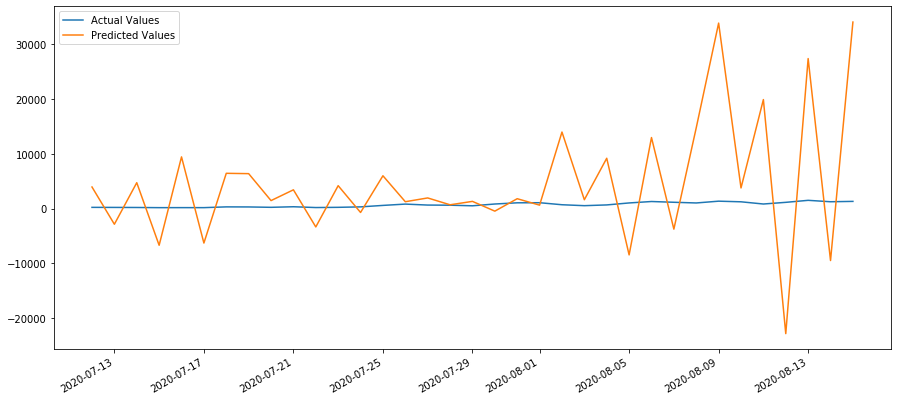

In [205]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [206]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 140842030.0
RMSE: 11867.69
MAE: 7999.94
R Squared: -784.43
Max Error: 32788.76


In [207]:
# make a prediction
y_train_pred = lr.predict(X_train)
y_train_pred .shape

(121, 7)

In [208]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(121, 7)

In [209]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [210]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [211]:
y_train_pred[0]

array([ 2.4654064, 17.255142 ,  8.126902 , 25.13377  , -6.986271 ,
       13.929119 , 10.181422 ], dtype=float32)

In [212]:
#For plot 
filter_indices = [0,5,11,17,23,29,35,41,47,53,59]
y_train_pred = y_train_pred [filter_indices ]

In [213]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [214]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(121, 35)

In [215]:
date_train.head(7)

22928   2020-03-02
22929   2020-03-03
22930   2020-03-04
22931   2020-03-05
22932   2020-03-06
22933   2020-03-07
22934   2020-03-08
Name: date, dtype: datetime64[ns]

In [216]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

127

In [217]:
date_train = date_train.values.flatten()

In [218]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [219]:
Y_train_pred.shape

(77,)

In [220]:
Y_train_real.shape

(77,)

In [221]:
date_train.shape

(134,)

In [222]:
date_train[nb_seq:].shape

(127,)

In [223]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-50

In [224]:
Y_train_real[:-suite_size].shape

(50,)

In [225]:
date_train[nb_seq:].shape

(127,)

In [226]:
Y_train_pred[:-suite_size].shape

(50,)

In [227]:
Y_train_real[:-suite_size].shape

(50,)

In [228]:
date_trainX = date_train[nb_seq:]

In [229]:
date_trainX[0:Y_train_pred.shape[0]].shape

(77,)

In [230]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [231]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [232]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [233]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-03-09,16.318817,2.465406
2020-03-10,16.318817,17.255142
2020-03-11,16.318817,8.126902
2020-03-12,6.993779,25.133770
2020-03-13,2.331260,-6.986271
2020-03-14,2.331260,13.929119
2020-03-15,25.643856,10.181422
2020-03-16,2.331260,-12.848017
2020-03-17,25.643856,25.558014


In [234]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-05-15,326.376343,310.592834
2020-05-16,410.301697,169.499313
2020-05-17,440.608063,235.331055
2020-05-18,440.608063,372.961029
2020-05-19,326.376343,344.829712
2020-05-20,379.995361,329.697357
2020-05-21,463.920654,317.072327
2020-05-22,356.682739,341.700012
2020-05-23,508.214630,411.586334


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

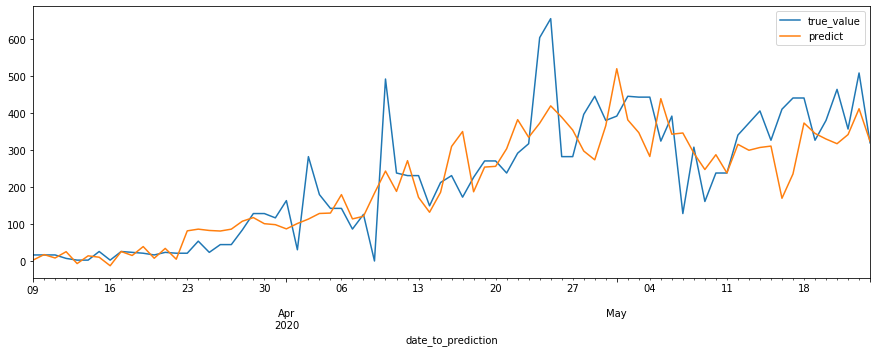

In [235]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [236]:
from sklearn import metrics
print('Train results')
print('MAE:', round(metrics.mean_absolute_error(Y_train_real_bis, Y_train_pred_bis), 2))
print('MSE:', round(metrics.mean_squared_error(Y_train_real_bis, Y_train_pred_bis), 2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train_real_bis, Y_train_pred_bis)))
print('R Squared:', round( metrics.r2_score(Y_train_real_bis, Y_train_pred_bis), 2))
print('Max Error:',round(  metrics.max_error(Y_train_real_bis, Y_train_pred_bis), 2))

Train results
MAE: 122.69
MSE: 37900.21
RMSE: 194.67975
R Squared: 0.46
Max Error: 1198.3


In [237]:
test_res.to_csv('./LR_res7.csv')

In [238]:
prediction_train.to_csv('./LR_res_train7.csv')